## Import Libraries

In [2]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [3]:
df = pd.read_csv("test.csv")

In [4]:
df.shape

(497, 33)

In [5]:
df.head(2)

,Unnamed: 0,Parking,Swimming Pool,Restaurant,Room Service,Fitness Centre,Spa & Wellness Centre,Business Centre,Facilities for Disabled,Airport Shuttle,...,Highspeed Internet,Airconditioning,Safe/Vault,Tennis Court,Indoor Pool,Pet-friendly,Casino,Golfcourse,Beach Access,Ski-In Ski-Out
0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df.drop(columns='Unnamed: 0' , inplace=True)
df.drop(columns='name' , inplace=True)

## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [7]:
numeric_col = [col for col in df.columns if df[col].dtype != 'object']
cate_col = [col for col in df.columns if df[col].dtype == 'object']        

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

#### 3. Feature selection

In [8]:
df['rate']

0      9.0
1      8.1
2      9.0
3      0.0
4      8.0
      ... 
492    8.4
493    7.5
494    0.0
495    8.0
496    8.8
Name: rate, Length: 497, dtype: float64

In [9]:
# Calculate the 35th and 75th percentiles of the price
p35 = df['rate'].quantile(0.35)
p75 = df['rate'].quantile(0.75)

# Function to categorize prices
def categorize_price(price):
    if price < p35:
        return 'Low_Rate'
    elif price < p75:
        return 'Good_Rate'
    else:
        return 'Hight_Rate'

# Apply the function to create a new column
df['rate'] = df['rate'].apply(categorize_price)

# df.drop('Rate', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['rate'].value_counts())

rate
Good_Rate     198
Low_Rate      168
Hight_Rate    131
Name: count, dtype: int64


In [10]:
df.head(2)

,Parking,Swimming Pool,Restaurant,Room Service,Fitness Centre,Spa & Wellness Centre,Business Centre,Facilities for Disabled,Airport Shuttle,Non-smoking Rooms,...,Highspeed Internet,Airconditioning,Safe/Vault,Tennis Court,Indoor Pool,Pet-friendly,Casino,Golfcourse,Beach Access,Ski-In Ski-Out
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# df = df[['rate' , 'review']]

In [12]:
encoder = LabelEncoder()
df['rate'] = encoder.fit_transform(df['rate'])  

#### 4. Prepare train and test data

In [13]:
# Prepare data
X = df


# sacle the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
X.shape

(497, 31)

## Buliding the Model

In [15]:
# 2. Use NearestNeighbors to find the optimal eps
min_samples = 2

In [16]:
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)

In [17]:
#indices

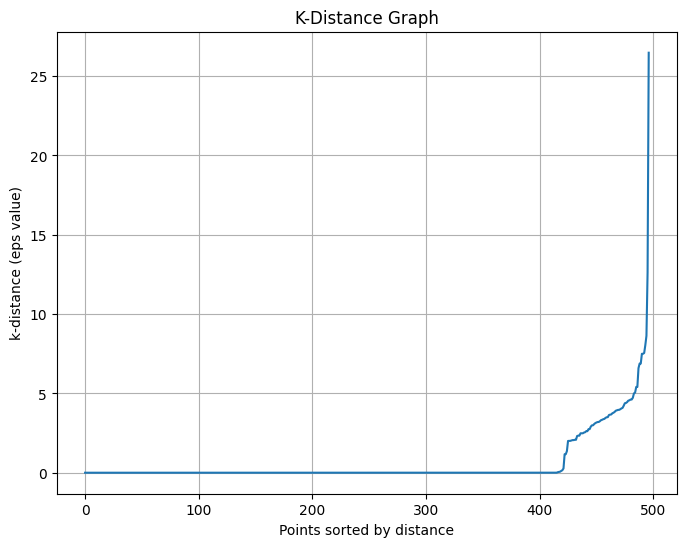

In [18]:
# The distance to the furthest neighbor (min_samples-th nearest) for each point
k_dist = distances[:, min_samples-1]

# Sort distances
k_dist_sorted = np.sort(k_dist)

# 3. Plotting the k-distance graph
plt.figure(figsize=(8, 6))
plt.plot(k_dist_sorted)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance (eps value)')
plt.grid(True)
plt.show()

In [19]:
# 4. Apply DBSCAN with chosen eps and min_samples
# Typically, you choose eps at the "elbow" point in this plot, where the slope changes significantly
chosen_eps = 7 # This is an example; choose this value based on the plot
dbscan = DBSCAN(eps=chosen_eps, min_samples=min_samples)

## Train the Model

In [20]:
# Fit the model on the training data

clusters = dbscan.fit_predict(X_scaled)

In [21]:
pd.Series(clusters).value_counts()

 1    471
-1      7
 0      3
 3      3
 5      3
 2      2
 4      2
 6      2
 7      2
 8      2
Name: count, dtype: int64

## Evaluating the Model 

In [22]:
silhouette_avg = silhouette_score(X, clusters)
silhouette_avg

-0.5834030215452416

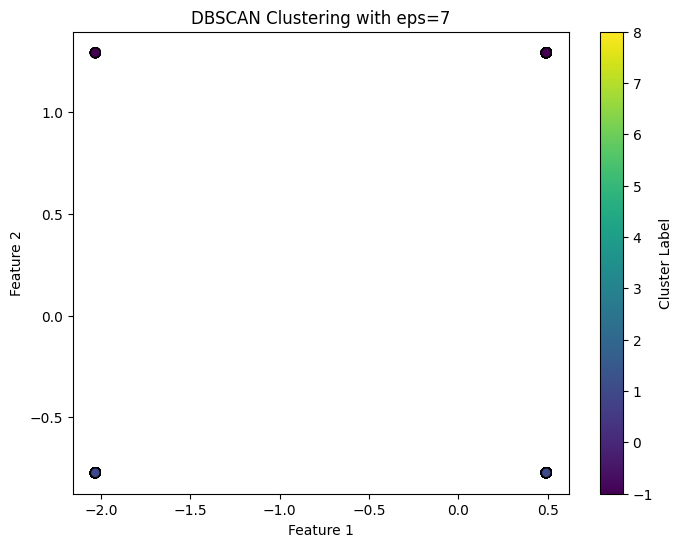

In [23]:
# 5. Plot the clustering result
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', s=50, edgecolor='k')
plt.title(f'DBSCAN Clustering with eps={chosen_eps}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [24]:
X['dbscan'] = clusters

In [25]:
X['dbscan'].value_counts()

dbscan
 1    471
-1      7
 0      3
 3      3
 5      3
 2      2
 4      2
 6      2
 7      2
 8      2
Name: count, dtype: int64

In [26]:
X.head()

,Parking,Swimming Pool,Restaurant,Room Service,Fitness Centre,Spa & Wellness Centre,Business Centre,Facilities for Disabled,Airport Shuttle,Non-smoking Rooms,...,Airconditioning,Safe/Vault,Tennis Court,Indoor Pool,Pet-friendly,Casino,Golfcourse,Beach Access,Ski-In Ski-Out,dbscan
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


<Axes: xlabel='rate', ylabel='review'>

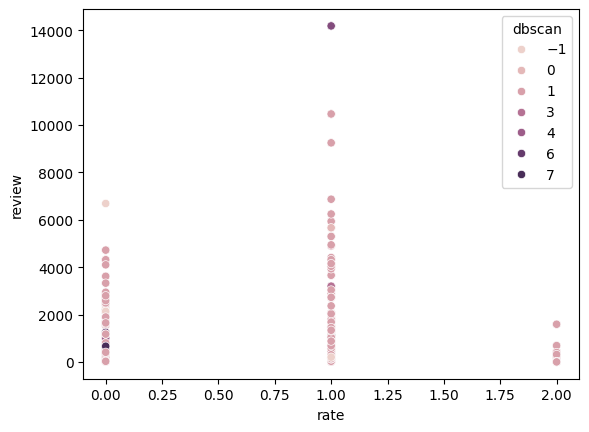

In [27]:
sns.scatterplot(data = X , x = 'rate', y = 'review', hue = 'dbscan')

<Axes: xlabel='rate', ylabel='review'>

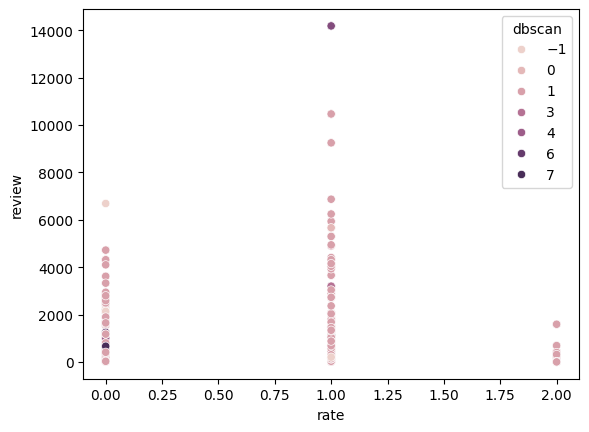

In [28]:
sns.scatterplot(data = X , x = 'rate', y = 'review', hue = 'dbscan')